## Fetch the Data and Visualize Data

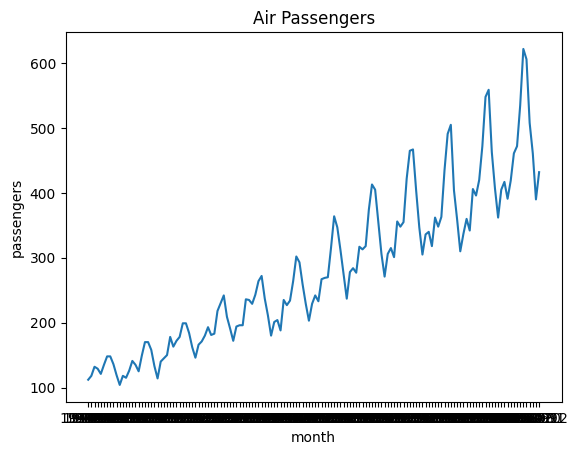

In [180]:
import pandas as pd
import matplotlib.pyplot as plt

# Fetch Data
data = pd.read_csv('data-sets/air_passengers.csv')

month = data['Month']
passengers = data['Passengers']

plt.plot(month, passengers)
plt.xlabel('month')
plt.ylabel('passengers')
plt.title('Air Passengers')
plt.show()

## Clean trend and seasonality from data

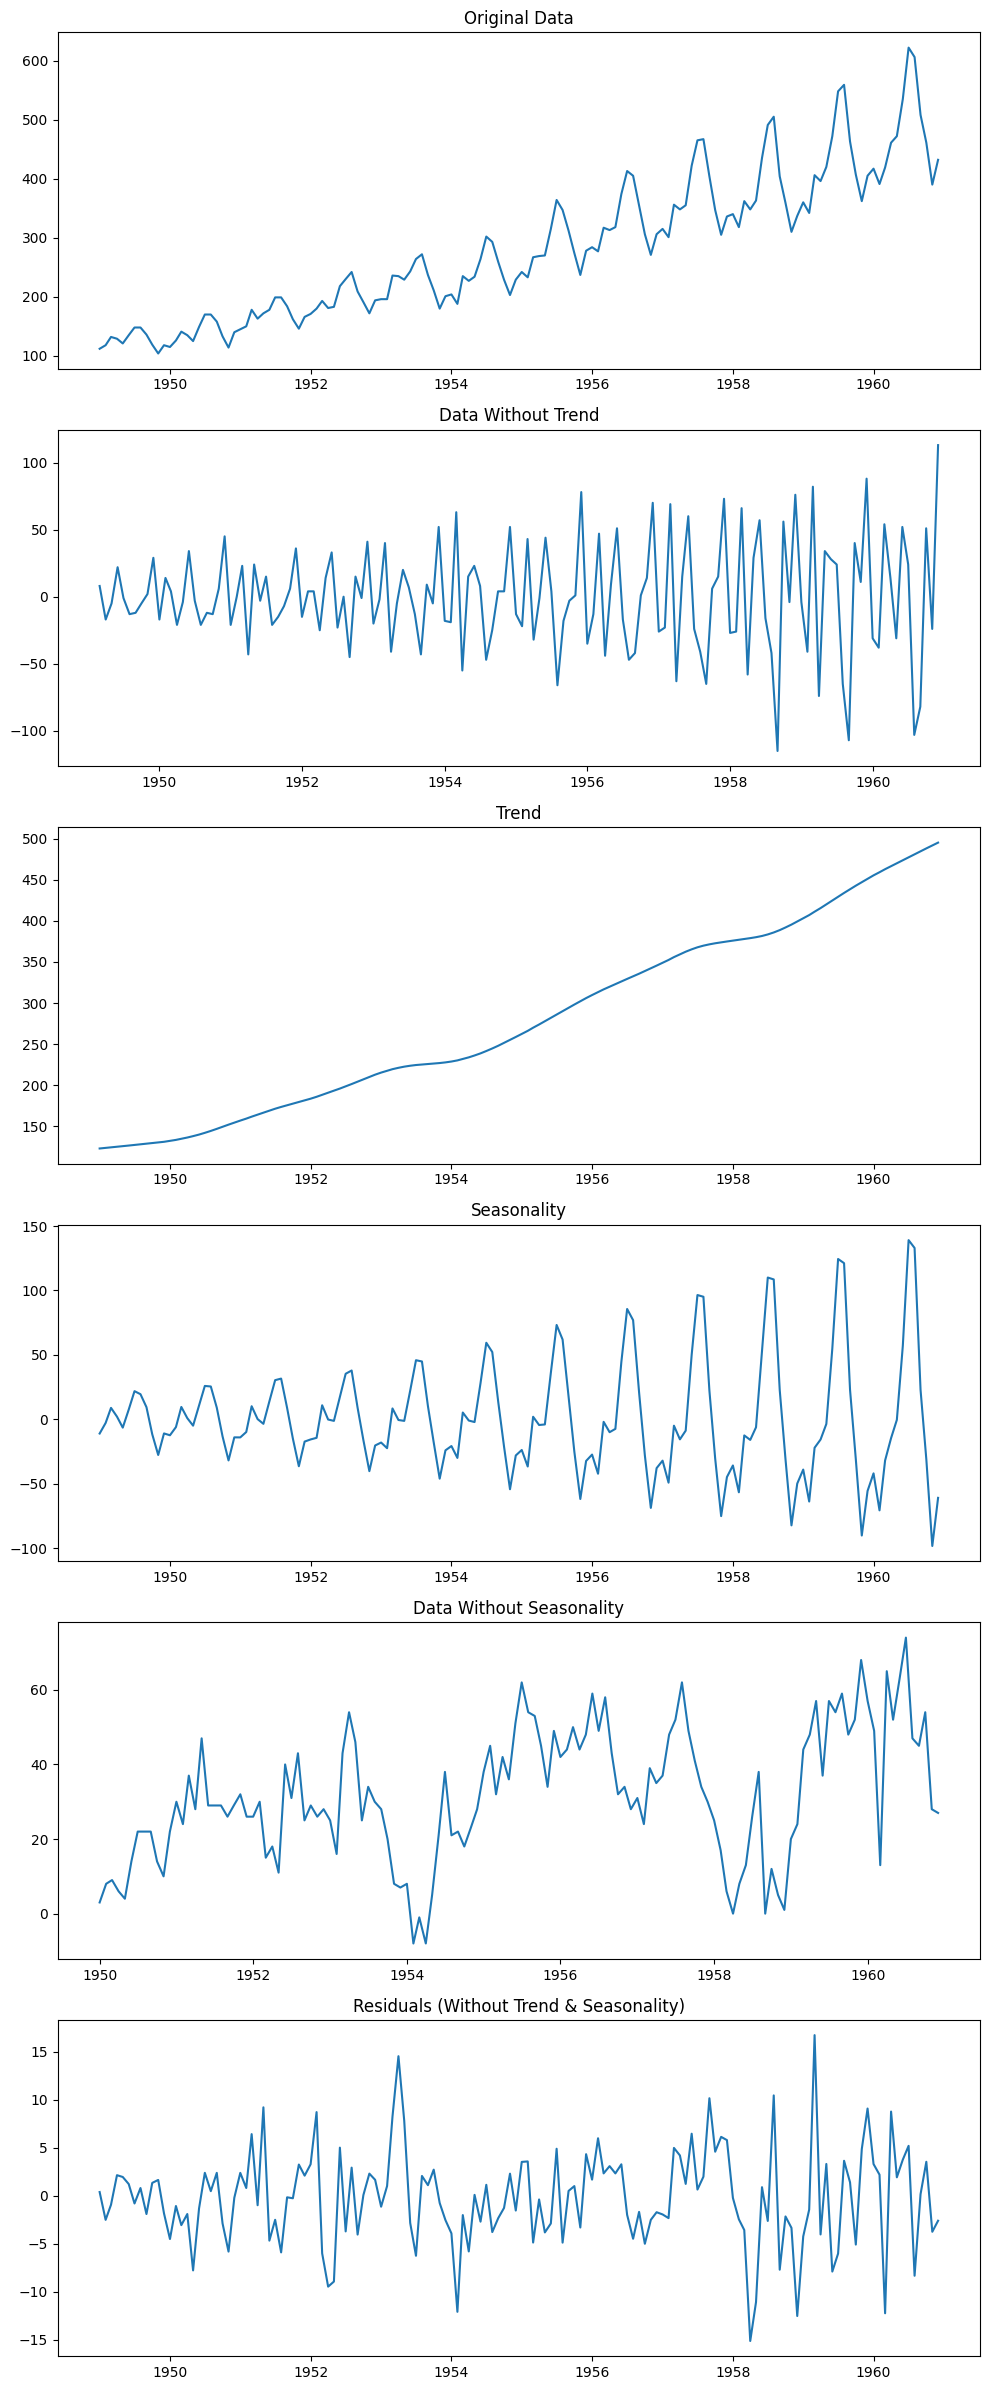

In [181]:
from statsmodels.tsa.seasonal import STL

# Assuming your data has a datetime column, set it as the index
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)

# Perform seasonal decomposition
decomp = STL(data).fit()

# Obtain the trend, seasonal, and residual components

# d = 2
data_without_trend = data['Passengers'].diff().diff()
trend = decomp.trend

# seasonality = 12
seasonal_period = 12
data_without_seasonality = data['Passengers'].diff(periods=seasonal_period)
seasonal = decomp.seasonal

residuals = decomp.resid
residuals_df = pd.DataFrame({'residuals': residuals})

# p = 2
residuals_df['t-1'] = residuals_df['residuals'].shift(1).values
residuals_df['t-2'] = residuals_df['residuals'].shift(2).values
residuals_df = residuals_df.dropna()

# Plot the original data, trend, and seasonality
plt.figure(figsize=(10, 24))

plt.subplot(6, 1, 1)
plt.plot(data)
plt.title('Original Data')

plt.subplot(6, 1, 2)
plt.plot(data_without_trend)
plt.title('Data Without Trend')

plt.subplot(6, 1, 3)
plt.plot(trend)
plt.title('Trend')

plt.subplot(6, 1, 4)
plt.plot(seasonal)
plt.title('Seasonality')

plt.subplot(6, 1, 5)
plt.plot(data_without_seasonality)
plt.title('Data Without Seasonality')

plt.subplot(6, 1, 6)
plt.plot(residuals)
plt.title('Residuals (Without Trend & Seasonality)')

plt.tight_layout()
plt.show()

## We will continue with the residuals data

In [182]:
import numpy as np
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
import pandas as pd



#residuals_df = residuals_df.round().astype(int)



residuals_df = residuals_df.drop(residuals_df.tail(2).index)
print(len(residuals_df))

data = data.reset_index(drop=True)
residuals_df = residuals_df.reset_index(drop=True)

print(data.index)
print(residuals_df.index)

140
RangeIndex(start=0, stop=144, step=1)
RangeIndex(start=0, stop=140, step=1)


In [183]:
train_size = int(len(residuals_df) * 0.80)
test_size = int(len(residuals_df) * 0.20)


train_data = residuals_df[:train_size]
test_data = residuals_df[train_size:]

In [184]:
from sklearn import svm

X_train = train_data[['t-1', 't-2']]
y_train = train_data['residuals']

print(X_train)
print(y_train)


model = svm.SVR()

           t-1        t-2
0    -2.506484   0.388692
1    -0.934435  -2.506484
2     2.143853  -0.934435
3     1.956051   2.143853
4     1.218765   1.956051
..         ...        ...
107  -0.222748   5.795205
108  -2.451104  -0.222748
109  -3.568232  -2.451104
110 -15.118422  -3.568232
111 -11.066837 -15.118422

[112 rows x 2 columns]
0      -0.934435
1       2.143853
2       1.956051
3       1.218765
4      -0.801732
         ...    
107    -2.451104
108    -3.568232
109   -15.118422
110   -11.066837
111     0.893651
Name: residuals, Length: 112, dtype: float64


BayesSearch

In [185]:
from sklearn.model_selection import KFold
from skopt import BayesSearchCV
from skopt.plots import plot_objective, plot_histogram
import skopt

# Decleartions for deprecated functions in numpy
np.float = float    
np.int = int    
np.object = object    
np.bool = bool    

# Define hyperparameters for bayesian optimization
param_space = {
    'kernel': ['rbf', 'sigmoid', 'poly', 'linear'],
    'C': (1e-6, 1e+1, 'log-uniform'),
    'gamma': (1e-6, 1e+1, 'log-uniform'),
    'epsilon': (1e-6, 1e+6, 'log-uniform')
    }


kFold = KFold(n_splits=3, shuffle=True, random_state=10)

bayes_search = BayesSearchCV(estimator=model, search_spaces=param_space, cv= kFold, n_jobs=-1, 
                             scoring='neg_mean_absolute_percentage_error', n_iter=5)

bayes_search.fit(X_train, y_train)

# Print the cross validation results
cv_results = bayes_search.cv_results_
cv_results_df = pd.DataFrame(cv_results)

cv_results_df['kernel'] = cv_results_df['params'].apply(lambda x: x['kernel'])
cv_results_df['C'] = cv_results_df['params'].apply(lambda x: x['C'])
cv_results_df['gamma'] = cv_results_df['params'].apply(lambda x: x['gamma'])
cv_results_df['epsilon'] = cv_results_df['params'].apply(lambda x: x['epsilon'])


print(cv_results_df[['mean_test_score', 'kernel', 'C', 'gamma', 'epsilon']])

# plot_objective creates pairwise dependence plot of the objective function.
# plot_objective(bayes_search.optimizer_results_[0],
#                    dimensions=["C", "gamma", "epsilon"],
#                    n_minimum_search=int(1e8))

# Print the best hyperparameters
print('Best hyperparameters:', bayes_search.best_params_)

best_model = bayes_search.best_estimator_


   mean_test_score  kernel         C     gamma        epsilon
0        -1.260666     rbf  0.001235  0.021286       0.003213
1        -1.305179     rbf  0.000007  8.726270       0.341815
2        -1.752003  linear  0.263114  0.034401       0.012918
3        -1.728112     rbf  3.145478  0.000032  101251.679221
4        -1.728112     rbf  0.001266  0.000034      89.140230
Best hyperparameters: OrderedDict([('C', 0.0012345056499065065), ('epsilon', 0.0032132487351010128), ('gamma', 0.02128612454271927), ('kernel', 'rbf')])


In [186]:
import matplotlib.pyplot as plt

X_test = test_data[['t-1', 't-2']]
y_test = test_data['residuals']


best_model.fit(X_train, y_train)
y_pred_resid = best_model.predict(X_test)


print(y_pred_resid - y_test)

112     2.442087
113   -10.626331
114     7.523442
115     1.976893
116     3.162389
117    12.335888
118     4.054617
119     1.257485
120   -16.905612
121     3.852767
122    -3.486306
123     7.719971
124     5.838858
125    -3.821617
126    -1.572645
127     4.915835
128    -5.042320
129    -9.254152
130    -3.473151
131    -2.362366
132    12.070020
133    -8.944362
134    -2.094293
135    -3.932550
136    -5.362677
137     8.162992
138    -0.341191
139    -3.716841
Name: residuals, dtype: float64


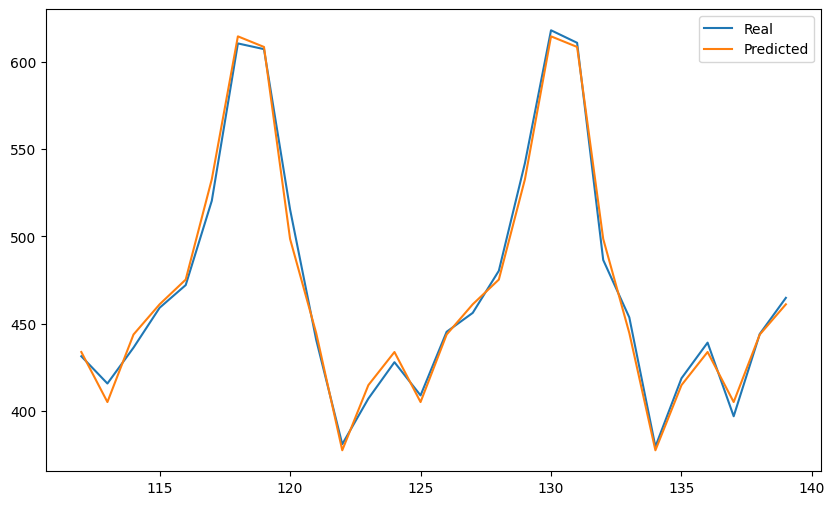

In [187]:
# Our seasonality is yearly (12 months)
seasonal_period = 12 

# Extend the last known value of the trend into the future.
last_known_trend = trend[-seasonal_period:].mean()

# trend_test = np.full(len(X_test), last_known_trend)

# Repeat the last complete seasonal cycle for future periods.
last_seasonal_cycle = seasonal[-seasonal_period:]
seasonal_test = np.tile(last_seasonal_cycle, len(X_test) // seasonal_period + 1)[:len(X_test)]


# Add back the trend and seasonal components.
y_pred = y_pred_resid + last_known_trend + seasonal_test
y_test = y_test + last_known_trend + seasonal_test 

# Plotting
plt.figure(figsize=(10,6))
plt.plot(y_test.index, y_test, label='Real')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

In [188]:
from sklearn.metrics import mean_absolute_percentage_error

mse = mean_absolute_percentage_error(y_test, y_pred)
print('Mean Squared Error on test set:', mse)

Mean Squared Error on test set: 0.012032629863544616
